In [ ]:
%pip install numpy pandas librosa scikit-learn catboost matplotlib seaborn

import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:

DATA_DIR = "/Users/dmwelch/Development/NYU/MIR/finalProj/Data/genres_original"

def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=30)
    features = np.array([])

    # MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    mfccs_mean = mfccs.mean(axis=1)
    features = np.hstack((features, mfccs_mean))

    # Chromagram
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = chroma.mean(axis=1)
    features = np.hstack((features, chroma_mean))

    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast_mean = contrast.mean(axis=1)
    features = np.hstack((features, contrast_mean))

    # Tonnetz
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    tonnetz_mean = tonnetz.mean(axis=1)
    features = np.hstack((features, tonnetz_mean))

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = zcr.mean()
    features = np.hstack((features, zcr_mean))

    # Spectral Roll-off
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rolloff_mean = rolloff.mean()
    features = np.hstack((features, rolloff_mean))

    return features

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
# dataset = []

# for genre in genres:
#     genre_dir = os.path.join(DATA_DIR, genre)
#     for filename in os.listdir(genre_dir):
#         if filename.endswith('.wav'):
#             file_path = os.path.join(genre_dir, filename)
#             features = extract_features(file_path)
#             dataset.append([features, genre])


# # Convert to DataFrame
# df = pd.DataFrame(dataset, columns=['features', 'label'])

import pickle

# # Save the DataFrame
# with open('dataset.pkl', 'wb') as f:
#     pickle.dump(df, f)

# Load the DataFrame
with open('dataset.pkl', 'rb') as f:
    df = pickle.load(f)

X = np.array(df['features'].tolist())
y = np.array(df['label'].tolist())

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)
ada_clf.fit(X_train, y_train)

cat_clf = CatBoostClassifier(
    iterations=100,
    learning_rate=0.5,
    depth=6,
    loss_function='MultiClass',
    verbose=False,
    random_state=42
)
cat_clf.fit(X_train, y_train)


/Users/dmw/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [3]:
from sklearn.metrics import classification_report

# AdaBoost Report
y_pred_ada = ada_clf.predict(X_test)
ada_report = classification_report(y_test, y_pred_ada, target_names=le.classes_, output_dict=True)
# print("AdaBoost Classification Report:")
# print(classification_report(y_test, y_pred_ada, target_names=le.classes_))

# CatBoost Report
y_pred_cat = cat_clf.predict(X_test)
cat_report = classification_report(y_test, y_pred_cat, target_names=le.classes_, output_dict=True)
# print("CatBoost Classification Report:")
# print(classification_report(y_test, y_pred_cat, target_names=le.classes_))

import pandas as pd

# Convert reports to DataFrames
ada_df = pd.DataFrame(ada_report).transpose()
cat_df = pd.DataFrame(cat_report).transpose()

# Drop aggregate metrics if you only want per-class metrics
ada_df = ada_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)
cat_df = cat_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)

# Reset index to have class names as a column
ada_df.reset_index(inplace=True)
ada_df.rename(columns={'index': 'class'}, inplace=True)
cat_df.reset_index(inplace=True)
cat_df.rename(columns={'index': 'class'}, inplace=True)

# Merge the two reports on class
combined_df = pd.merge(ada_df, cat_df, on='class', suffixes=('_AdaBoost', '_CatBoost'))

# Melt the DataFrame for seaborn
melted_df = combined_df.melt(id_vars='class', 
                             value_vars=['precision_AdaBoost', 'precision_CatBoost',
                                         'recall_AdaBoost', 'recall_CatBoost',
                                         'f1-score_AdaBoost', 'f1-score_CatBoost'],
                             var_name='Metric_Model', 
                             value_name='Score')

# Split Metric_Model into separate Metric and Model columns
melted_df[['Metric', 'Model']] = melted_df['Metric_Model'].str.split('_', expand=True)
melted_df.drop('Metric_Model', axis=1, inplace=True)

import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(15, 18))

# List of metrics to plot
metrics = ['precision', 'recall', 'f1-score']

# Iterate over the metrics and create subplots
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 1, i)
    
    # Filter the DataFrame for the current metric
    data = melted_df[melted_df['Metric'] == metric]
    
    # Create a barplot
    sns.barplot(x='class', y='Score', hue='Model', data=data)
    
    # Set plot titles and labels
    plt.title(f'{metric.capitalize()} by Genre and Model', fontsize=16)
    plt.xlabel('Genre', fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust legend
    plt.legend(title='Model', fontsize=12, title_fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

Matplotlib is building the font cache; this may take a moment.


ModuleNotFoundError: No module named 'seaborn'

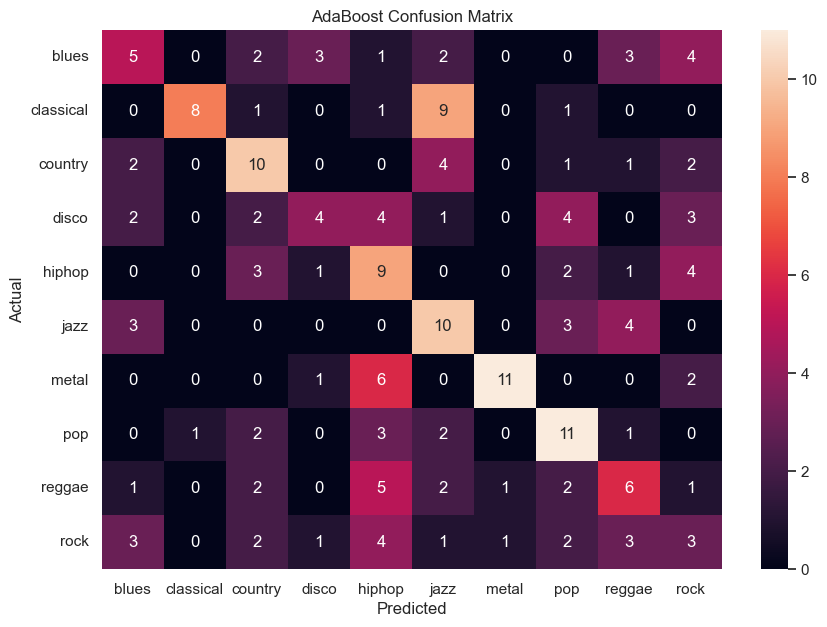

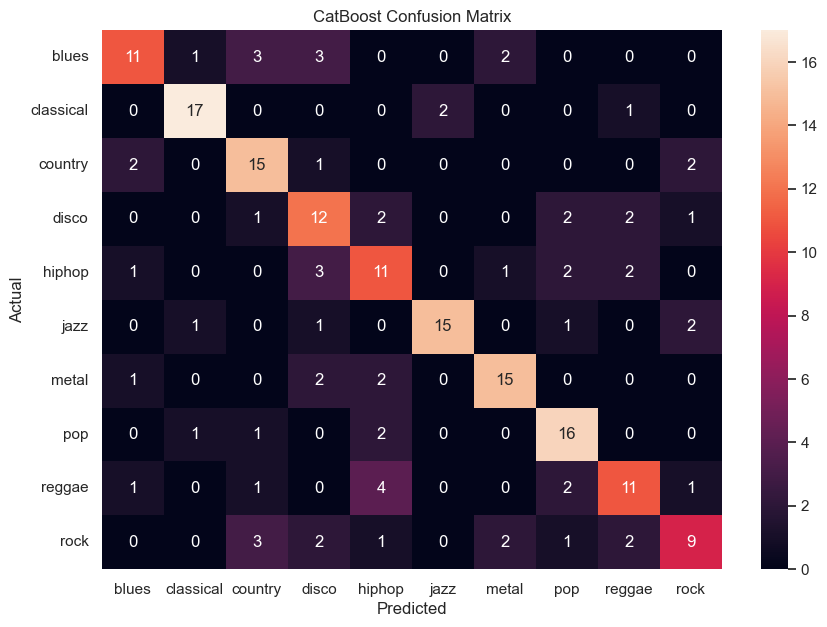

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# AdaBoost Confusion Matrix
cm_ada = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(10,7))
sns.heatmap(cm_ada, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('AdaBoost Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# CatBoost Confusion Matrix
cm_cat = confusion_matrix(y_test, y_pred_cat)
plt.figure(figsize=(10,7))
sns.heatmap(cm_cat, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('CatBoost Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()